<a href="https://colab.research.google.com/github/Jasper-Hewitt/privatestuff/blob/main/Chiang_Twitter_predict_unlabelled_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

In [1]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.1 MB/s 
     |████████████████████████████████| 182 kB 17.2 MB/s 
     |████████████████████████████████| 132 kB 17.2 MB/s 
     |████████████████████████████████| 212 kB 16.3 MB/s 
     |████████████████████████████████| 127 kB 22.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.5 MB/s 
     |████████████████████████████████| 7.6 MB 56.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 4.1 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninsta

In [2]:
#import our model from huggingface
number_classes = 2
model_tokenizer = "hfl/chinese-bert-wwm"

if number_classes == 2:
    model_classifier = "owen198/weibo-wmmbert-2"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [3]:
model_classifier

'owen198/weibo-wmmbert-2'

# 1. load and clean data

In [4]:
#insert new xlsx file here
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/scrap1.xlsx

--2022-12-09 06:29:52--  https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/scrap1.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106058 (104K) [application/octet-stream]
Saving to: ‘scrap1.xlsx’

scrap1.xlsx         100%[===================>] 103.57K  --.-KB/s    in 0.02s   

2022-12-09 06:29:52 (6.20 MB/s) - ‘scrap1.xlsx’ saved [106058/106058]



In [5]:
import pandas as pd

In [12]:
#insert new xlsx file here
testing_pd = pd.read_excel('/content/scrap1.xlsx')
testing_pd = testing_pd[['Text']]
testing_pd = testing_pd.rename(columns={'Text':'text'})

In [13]:
#dirty data
testing_pd

,text
0,FelixChang 台灣獨立建國志願軍\n@FelixCh29980680\n·\n10m...
1,FelixChang 台灣獨立建國志願軍\n@FelixCh29980680\n·\n1h對...
2,就是辣個威廉子\n@williamt0509\n·\n1h柯文哲卸任當天，我打算在頂樓施放煙...
3,再見 再也不見\n@Mdca92W2MQdSqHM\n·\n1hReplying to \n...
4,Ken Huang\n@kenhuang0813\n·\n2h台北市準市長蔣萬安先生接受媒體...
...,...
459,nizu\n@Nizu_taiwan\n·\n28 Nov但我還是覺得蔡英文好可憐，整體來說...
460,BIue\n@Blue01530961\n·\n28 NovReplying to \n@m...
461,aoi\n@aoi_sung\n·\n28 NovRT>明年228紀念活動是蔣萬安主持。\n...
462,記者爆料網\n@NlCnIRJVzzoTgSI\n·\n28 Nov蔣萬安翻轉台北 他曾祖父...


In [16]:
#we can consider not deleting the titles. This will be up to the ICI project group to decide
#if you wish to preserve the titles. replace the corresponding block of code below with this one 

#testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True)#.replace(title_pattern_1,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
##testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
#________________________________________________________________________________________________________________________

testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]


import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
#title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'
twitter_username='@([A-Za-z0-9_]+)'
letters='[A-z]'
newline_symbols='/\r?\n|\r/'
numbers='[0-9]'

#replace with this block. Do some more research because it looks like some titles are still removed, like index 41
testing_pd['text'] = testing_pd['text'].replace(twitter_username,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(letters,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(newline_symbols,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(numbers,'',regex=True)

In [17]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text
0,台灣獨立建國志願軍\n\n·\n \n\n那陳時中可以去控告周玉蔻啊！\n他這時不告，什...
1,"台灣獨立建國志願軍\n\n·\n對手罵陳時中""謀財害命""，他不提告；\n對手抹黑陳時中和周..."
2,就是辣個威廉子\n\n·\n柯文哲卸任當天，我打算在頂樓施放煙火，但會不會被誤會成想慶祝蔣萬...
3,再見 再也不見\n\n·\n \n\n柯還沒有交接 蔣萬安還沒上任 沒權力處理
4,\n\n·\n台北市準市長蔣萬安先生接受媒體提問小內閣人事時，用了煮飯不要太早掀開鍋蓋來答...
...,...
459,\n\n·\n 但我還是覺得蔡英文好可憐，整體來說推崇的價值我都支持，但身為台灣難得的進步派...
460,\n\n·\n \n\n那不行，既然他們選了，我就得笑。\n就好像我們台北人前有柯文哲後...
461,\n\n·\n >明年紀念活動是蔣萬安主持。\n\n真的有夠魔幻。\n蔣萬安是要去下跪的嗎？...
462,記者爆料網\n\n·\n 蔣萬安翻轉台北 他曾祖父的老家在這裡\n-.\n蔣萬安翻轉台北 他...


## 1-2 Tokenization

In [18]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [19]:
from transformers import AutoTokenizer

In [20]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [21]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
full_test_dataset = tokenized_datasets["test"]

# 2. preparing BERT


In [23]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=2)

Downloading:   0%|          | 0.00/909 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [24]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-24-e1ee7db0da93>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [25]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [26]:
import numpy as np

#prediction results


In [27]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 464
  Batch size = 8


In [28]:
pred

PredictionOutput(predictions=array([[ 2.412252  , -3.5054924 ],
       [ 1.5599163 , -1.9608803 ],
       [ 2.2871494 , -3.0386927 ],
       [ 2.465505  , -3.6437442 ],
       [-1.641112  ,  1.5484838 ],
       [ 1.6868187 , -2.2059352 ],
       [-1.8405597 ,  1.8181505 ],
       [-2.2452548 ,  2.3737385 ],
       [ 1.5002825 , -1.8186722 ],
       [-1.7694094 ,  1.7058855 ],
       [ 2.2138753 , -2.8645291 ],
       [ 0.93472105, -0.47090378],
       [ 2.3052626 , -3.1127396 ],
       [ 2.1782503 , -2.8107815 ],
       [ 1.7916417 , -2.363199  ],
       [ 2.399891  , -3.4703069 ],
       [ 1.6460879 , -2.133122  ],
       [ 1.9351405 , -2.5339885 ],
       [ 2.3779294 , -3.4044433 ],
       [ 1.899402  , -2.4942455 ],
       [-2.0134091 ,  2.088311  ],
       [-2.5918846 ,  2.6277962 ],
       [-2.3743958 ,  2.4833596 ],
       [ 1.6659524 , -2.1694663 ],
       [ 2.1291282 , -2.7478597 ],
       [ 2.0386956 , -2.645789  ],
       [ 1.7137829 , -2.2503703 ],
       [ 1.6858194 , -2.20

In [29]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,

In [30]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [31]:
#final table. Remember, 0 = negative, 1 = positive
testing_pd

,text,pred
0,台灣獨立建國志願軍\n\n·\n \n\n那陳時中可以去控告周玉蔻啊！\n他這時不告，什...,0
1,"台灣獨立建國志願軍\n\n·\n對手罵陳時中""謀財害命""，他不提告；\n對手抹黑陳時中和周...",0
2,就是辣個威廉子\n\n·\n柯文哲卸任當天，我打算在頂樓施放煙火，但會不會被誤會成想慶祝蔣萬...,0
3,再見 再也不見\n\n·\n \n\n柯還沒有交接 蔣萬安還沒上任 沒權力處理,0
4,\n\n·\n台北市準市長蔣萬安先生接受媒體提問小內閣人事時，用了煮飯不要太早掀開鍋蓋來答...,1
...,...,...
459,\n\n·\n 但我還是覺得蔡英文好可憐，整體來說推崇的價值我都支持，但身為台灣難得的進步派...,0
460,\n\n·\n \n\n那不行，既然他們選了，我就得笑。\n就好像我們台北人前有柯文哲後...,0
461,\n\n·\n >明年紀念活動是蔣萬安主持。\n\n真的有夠魔幻。\n蔣萬安是要去下跪的嗎？...,0
462,記者爆料網\n\n·\n 蔣萬安翻轉台北 他曾祖父的老家在這裡\n-.\n蔣萬安翻轉台北 他...,1


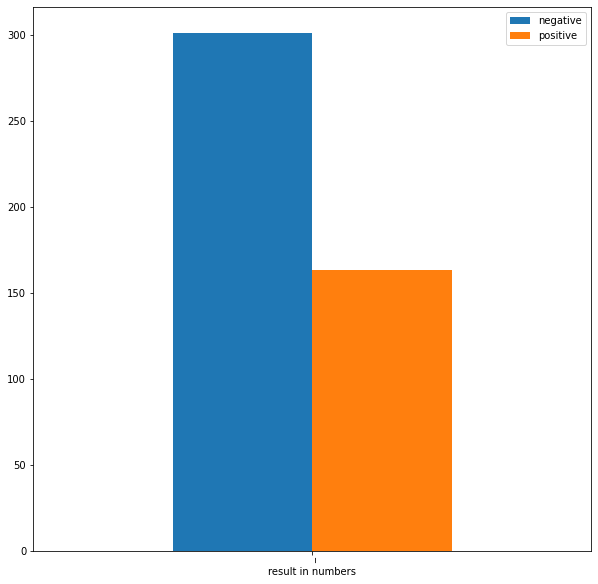

In [32]:
#plot in total amounts. Remember, 0 = negative, 1 = positive
import pandas as pd
import matplotlib.pyplot as plt
count0 = (testing_pd['pred'] == 0).sum()
count1 = (testing_pd['pred'] == 1).sum()
df_plot=pd.DataFrame({'result in numbers': ['_'], 'negative':[count0], 'positive': [count1]})
df_plot.plot.bar(x='result in numbers', figsize=(10, 10))
plt.show()

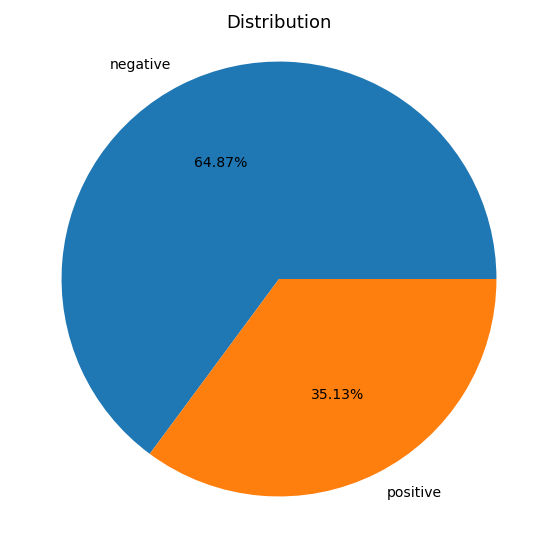

In [33]:
#plot in percentage. Remember, 0 = negative, 1 = positive
def Percentage(num1, num2):
    return num1 / (num1 + num2) * 100

per1=Percentage(count0, count1)
per2=Percentage(count1, count0)

label = ['negative', 'positive']
shares = [per1, per2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(shares, labels=label, autopct='%.2f%%', shadow=False, labeldistance=1.1,  textprops={'fontsize': 14})
ax.set_title('Distribution', fontsize=18, y=0.95);